<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Ice-age dynamics: 7. Ice models
## 2D Ice-sheet modelling
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we model and plot **two-dimensional ice-sheet models** defined in the lecture, using `python`.

We first initialize the `python` libraries.

In [1]:
import numpy as np
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import ipywidgets as widgets

## Simple plastic ice-sheet model

$$
\frac{\displaystyle dh_{surface}}{\displaystyle dx}
=
\frac{\displaystyle \tau}{\displaystyle \rho g h_{ice}}
$$
with $x$ profile distance, $h_{ice}$ ice-sheet thickness, $h_{surface}$ topographical surface,
$\tau$ shear strength along ice-bedrock interface,
$\rho$ ice density, and
$g$ gravitational acceleration.

How to proceed from here? 

- set up fields for 
    - profile (`profile`)
    - bedrock (`bedrock`)
    - ice thickness (`ice`)
    - topography (`topo`) 
    - shear stress (`shear`)
- Define margin (`ice[0]=0` and `topo[0]=bedrock[0]`)
- Use analytic solution of parabolic ice sheet at second point: 
$h_{ice}[1]=\sqrt{\frac{2\tau}{\rho g} x}$
- continue along profile with differential equation: 
$h_{surface}[i]=h_{surface}[i-1] + \frac{\tau}{\rho g h_{ice}[i-1]} dx$

In [2]:
"""
Simple 2D ice-sheet model, purely geometrical
"""
# define parameter values
density = 910.  # kg/m3
gravity = 9.81  # m/s2
taur    = 1.e5  # Pa

def plot_profile(t1,t2):
    # define profile kink points (x) and topography (y)
    x = [0.,100.e3,200.e3]
    y = [0.,t1*1000,t2*1000]
    # prepare linear (or quadratic) interpolation
    #f1 = interp1d(x, y, kind='linear')
    f1 = interp1d(x, y, kind='quadratic')
    # interpolate to denser grid
    n = 401
    profile = np.linspace(0,200.e3,n,endpoint=True)
    bedrock = f1(profile)
    # define vector fields
    shear = np.full((len(profile)),taur)
    ice   = np.zeros(len(profile))
    topo  = np.zeros(len(profile))
    # fix snout values
    ice[0]  = 0.
    topo[0] = bedrock[0]
    # calculate ice height at second point from parabolic profile
    ice[1]  = np.sqrt(2.*shear[1]/density/gravity*profile[1])
    topo[1] = bedrock[1] + ice[1]
    # loop
    for i in range(2,n):
        topo[i]  = topo[i-1] + shear[i-1] / (density*gravity) * (profile[i]-profile[i-1])/ice[i-1]
        ice[i]   = topo[i] - bedrock[i]
    # plot time series
    plt.figure(figsize=(12.0, 6.0))
    plot1=plt.subplot2grid((3,2), (0,0), colspan=2,rowspan=3)
    #plot2=plt.subplot2grid((3,2), (1,0), colspan=2,rowspan=1)
    #plot3=plt.subplot2grid((3,2), (2,0), colspan=2,rowspan=1)
    plot1.set_xlabel('Profile [km]')
    plot1.set_ylabel('Elevation [km]')
    plot1.set_title('Plastic ice sheet profile')
    plot1.fill_between(profile/1000,-0.1,bedrock/1000,color='brown',linestyle='-',linewidth=1,label='Topo')
    plot1.fill_between(profile/1000,bedrock/1000,topo/1000,color='blue',linestyle='-',linewidth=1,label='Ice')
    plot1.set_xlim([0,200])
    plot1.set_ylim([-0.1,4.0])
    #plot1.axes.get_xaxis().set_visible(False)
    #plot1.spines['bottom'].set_visible(False)
    plot1.legend(loc='upper left')

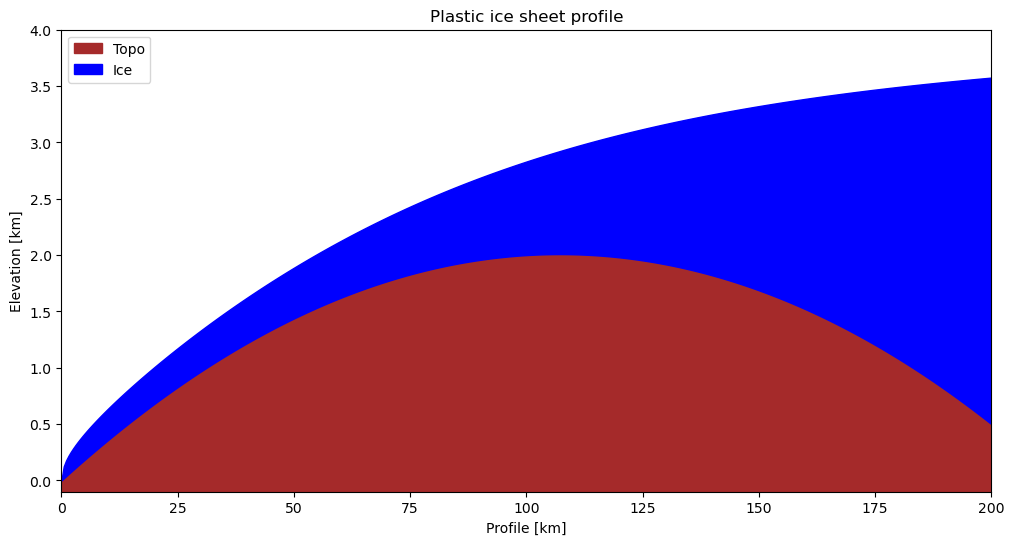

In [3]:
plot_profile(2,0.5)

In [4]:
# call interactive module
w = dict(
t1=widgets.FloatSlider(min=0,max=3,step=0.1,value=0,description='t1 [km]'),
t2=widgets.FloatSlider(min=0,max=3,step=0.1,value=0,description='t2 [km]'))

output = widgets.interactive_output(plot_profile, w)
box = widgets.VBox([widgets.HBox([*w.values()]), output])
display(box)

## Ice-sheet models with mass balance
$$
 \frac{\displaystyle dh_{surface}}{\displaystyle dx} = \frac{\displaystyle A_s}{\displaystyle \rho g}
 \frac{\displaystyle \left[ a(L-R) + b(R-x) \right]^{1 \over m}}{\displaystyle h_{ice}^{1+{1 \over m}}}
$$

In [5]:
"""
Mass-balance 2D ice-sheet model
"""
# define parameter values
density = 910.  # kg/m3
gravity = 9.81  # m/s2
taur    = 1.e5  # Pa
am      = 40.
m       = 2.5
a       = am**m

def plot_profile(t1,t2,ela,abl,acc):
    # define profile kink points (x) and topography (y)
    x = [0.,100.e3,200.e3]
    y = [0.,t1*1000,t2*1000]
    # prepare linear interpolation
    f1 = interp1d(x, y, kind='linear')
    # interpolate to denser grid
    n = 401
    profile = np.linspace(0,200.e3,n,endpoint=True)
    bedrock = f1(profile)
    # define vector fields
    shear = np.full((len(profile)),taur)
    ice   = np.zeros(len(profile))
    topo  = np.zeros(len(profile))
    # fix snout values
    ice[0]  = 0.
    topo[0] = bedrock[0]
    # calculate ice height at second point from parabolic profile
    ice[1]  = np.sqrt(2.*shear[1]*profile[1]/density/gravity)
    topo[1] = bedrock[1] + ice[1]
    # loop
    for i in range(2,n):
        dx = profile[i] - profile[i-1]
        #if (profile[i] <= ela*1000):
        #    dheight     = a * (abl*float(i)*dx)**(1./m) / (density*gravity)/ice[i-1]**(1.+1./m)*dx
        #else:
        #    dheight     = a * (acc*(profile[n-1]-float(i)*dx))**(1./m) / (density*gravity)/ice[i-1]**(1.+1./m)*dx
            
        if (profile[i] <= ela*1000):
            dheight     = ((a/(density*gravity)/ice[i-1]**(1.+1./m) 
                        * (-abl*(ela*1000-float(i)*dx) + acc*(profile[n-1]-ela*1000))**(1./m)))*dx
        else:
            dheight     = ((a/(density*gravity)/ice[i-1]**(1.+1./m) 
                        * (acc*(profile[n-1]-ela*1000))**(1./m)))*dx
            
        topo[i]  = topo[i-1] + dheight
        ice[i]   = topo[i] - bedrock[i]
    # plot time series
    plt.figure(figsize=(12.0, 6.0))
    plot1=plt.subplot2grid((3,2), (0,0), colspan=2,rowspan=3)
    #plot2=plt.subplot2grid((3,2), (1,0), colspan=2,rowspan=1)
    #plot3=plt.subplot2grid((3,2), (2,0), colspan=2,rowspan=1)
    plot1.set_xlabel('Profile [km]')
    plot1.set_ylabel('Elevation [km]')
    plot1.set_title('Plastic ice sheet profile')
    plot1.fill_between(profile/1000,-0.4,bedrock/1000,color='brown',linestyle='-',linewidth=1,label='Topo')
    plot1.fill_between(profile/1000,bedrock/1000,topo/1000,color='blue',linestyle='-',linewidth=1,label='Ice')
    plot1.plot([0,ela],[-0.3,-0.3],color='black',linestyle='-',linewidth=10)
    plot1.plot([ela,200],[-0.3,-0.3],color='lightgray',linestyle='-',linewidth=10)
    plot1.set_xlim([0,200])
    plot1.set_ylim([-0.4,4.0])
    #plot1.axes.get_xaxis().set_visible(False)
    #plot1.spines['bottom'].set_visible(False)
    plot1.legend(loc='upper left')
    
#plot_profile(1000,1500)

# call interactive module
w = dict(
t1=widgets.FloatSlider(min=0,max=3,step=0.1,value=0,description='t1 [km]'),
t2=widgets.FloatSlider(min=0,max=3,step=0.1,value=0,description='t2 [km]'),
ela=widgets.IntSlider(min=0,max=200,step=10,value=0,description='ELA [km]'),
abl=widgets.FloatSlider(min=0,max=2,step=0.1,value=1,description='Ablation-zone [m/yr]'),
acc=widgets.FloatSlider(min=0,max=3,step=0.1,value=2,description='Accumulation-zone [m/yr]'))
output = widgets.interactive_output(plot_profile, w)
box = widgets.HBox([widgets.VBox([*w.values()]), output])
display(box)

## Example: Cross section of Scandinavia

In [7]:
"""
Mass-balance 2D ice-sheet model
"""
# define parameter values
density = 910.  # kg/m3
gravity = 9.81  # m/s2
am      = 10.
m       = 2.5
a       = am**m

#-----------------------------------------------------------------------
# read data into field
#-----------------------------------------------------------------------
infile1='data/fenno_topo_65N.xy'
profile=np.loadtxt(fname=infile1,skiprows=1,usecols=0)
bedrock=np.loadtxt(fname=infile1,skiprows=1,usecols=1)
n = bedrock.shape[0]
print(profile.min(),profile.max(),n)
print(bedrock.min(),bedrock.max(),n)
# parameter values
xmin     = 0.; xmax     = 2345.
topo_min = -1.0; topo_max = 2.0
shear_left = 1.e4; shear_right = 1.e4
acc1 = 2.0; acc2 = 0.5
abl1 = -1.0; abl2 = -1.0

def plot_fenno(moraine1,moraine2,ela1,ela2,summit_max):
    # parameter values
    summit   = int(0.5*(moraine1 + moraine2))
    ice   = np.zeros(len(profile))
    topo  = np.zeros(len(profile))
    # calculate ice on left side
    factor = 2.0*shear_left / density / gravity
    for j in range(summit_max):
        for i in range(0,moraine1):
            ice[i]  = 0.
            topo[i] = bedrock[i] + ice[i]
        for i in range(moraine1,summit):
            if (i == moraine1): # snout value
                dheight = 0.
                ice[i]  = 0.
                topo[i] = bedrock[i] + ice[i]
            elif (i == moraine1+1): # second value from parabolic profile
                dheight = 0.
                ice[i]  = np.sqrt(factor *(profile[i]-profile[moraine1]))
                topo[i] = bedrock[i] + ice[i]
            else:
                dheight     = (a/(density*gravity)/ice[i-1]**(1.+1./m)
                            *(acc1*(profile[summit]-profile[i]+profile[moraine1]))**(1./m)
                            *(profile[i]-profile[i-1]))
                topo[i]  = topo[i-1] + dheight
                ice[i]   = topo[i] - bedrock[i]

        # calculate ice on right side
        factor = 2.0*shear_right / density /gravity
        for i in range(n-1,moraine2,-1):
            ice[i]  = 0.
            topo[i] = bedrock[i] + ice[i]
        for i in range(moraine2,summit-1,-1):
            if (i == moraine2): # snout value
                dheight = 0.
                ice[i]  = 0.
                topo[i] = bedrock[i] + ice[i]
            elif (i == moraine2-1): # second value from parabolic profile
                dheight = 0.
                ice[i]  = np.sqrt(factor *(-profile[i]+profile[moraine2]))
                topo[i] = bedrock[i] + ice[i]
            else:
                dheight     = (a/(density*gravity)/ice[i+1]**(1.+1./m)
                            *(acc2*(profile[summit]-profile[i]+profile[moraine2]))**(1./m)
                            *(profile[i+1]-profile[i]))
                topo[i]  = topo[i+1] + dheight
                ice[i]   = topo[i] - bedrock[i]
            #ice[i]  = np.sqrt(factor *(-profile[i]+profile[moraine2]))
            #topo[i] = bedrock[i] + ice[i]
        # check for summit height
        summit_diff = topo[summit-1] - topo[summit]
        if (summit_diff <= 0.):
            summit = summit + 1
        if (summit_diff >  0.):
            summit = summit - 1
        
    # plot elevations
    plt.figure(figsize=(12.0, 6.0))
    plot1=plt.subplot2grid((3,2), (0,0), colspan=2,rowspan=3)
    #plot2=plt.subplot2grid((3,2), (1,0), colspan=2,rowspan=1)
    #plot3=plt.subplot2grid((3,2), (2,0), colspan=2,rowspan=1)
    plot1.set_xlabel('Profile [km]')
    plot1.set_ylabel('Elevation [km]')
    plot1.set_title('Fennoscandia at 65$^{\circ}$N')
    plot1.fill_between(profile/1000,topo_min,0.0,color='lightblue',linestyle='-',linewidth=1,label='Ocean')
    plot1.fill_between(profile/1000,topo_min,bedrock/1000,color='brown',linestyle='-',linewidth=1,label='Topo')
    plot1.fill_between(profile/1000,bedrock/1000,topo/1000,color='blue',linestyle='-',linewidth=1,label='Ice')
    plot1.plot([xmin,profile[ela1]/1000],[topo_min+0.1,topo_min+0.1],color='black',linestyle='-',linewidth=10)
    plot1.plot([profile[ela1]/1000,profile[ela2]/1000],[topo_min+0.1,topo_min+0.1],color='lightgray',linestyle='-',linewidth=10)
    plot1.plot([profile[ela2]/1000,xmax],[topo_min+0.1,topo_min+0.1],color='black',linestyle='-',linewidth=10)
    plot1.plot(profile[moraine1]/1000,bedrock[moraine1]/1000,color='yellow',marker='o',markersize=10)
    plot1.plot(profile[moraine2]/1000,bedrock[moraine2]/1000,color='yellow',marker='o',markersize=10)
    plot1.plot(profile[summit]/1000,topo_max-0.2,color='red',marker='o',markersize=5)
    #plot1.plot([ela,200],[-0.3,-0.3],color='lightgray',linestyle='-',linewidth=10)
    plot1.set_xlim([xmin,xmax])
    plot1.set_ylim([topo_min,topo_max])
    #plot1.axes.get_xaxis().set_visible(False)
    #plot1.spines['bottom'].set_visible(False)
    plot1.legend(loc='upper left')
    
# call interactive module
w = dict(
moraine1=widgets.IntSlider(min=0,max=n,step=10,value=120,description='Moraine (left)'),
moraine2=widgets.IntSlider(min=0,max=n,step=10,value=200,description='Moraine (right)'),
ela1=widgets.IntSlider(min=0,max=n-1,step=1,value=0,description='ELA (left)'),
ela2=widgets.IntSlider(min=0,max=n-1,step=1,value=n-1,description='ELA(right)'),
summit_max=widgets.IntSlider(min=1,max=150,step=1,value=1,description='summit iterations'))

output = widgets.interactive_output(plot_fenno, w)
box = widgets.HBox([widgets.VBox([*w.values()]), output])
display(box)

0.0 2344950.79 501
-3013.58 798.47 501


... done